## Step 3 - Climate Analysis and Exploration

You are now ready to use Python and SQLAlchemy to do basic climate analysis and data exploration on your new weather station tables. All of the following analysis should be completed using SQLAlchemy ORM queries, Pandas, and Matplotlib.

* Create a Jupyter Notebook file called `climate_analysis.ipynb` and use it to complete your climate analysis and data exporation.

* Choose a start date and end date for your trip. Make sure that your vacation range is approximately 3-15 days total.

* Use SQLAlchemy `create_engine` to connect to your sqlite database.

* Use SQLAlchemy `automap_base()` to reflect your tables into classes and save a reference to those classes called `Station` and `Measurement`.

In [1]:
# Dependencies, Toolkit and ORM
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
from sqlalchemy import Column, Integer, String, Float, Text, ForeignKey
import datetime as dt
import pandas as pd
import matplotlib
from matplotlib import style
import matplotlib.pyplot as plt
import numpy as np
style.use('seaborn')

In [2]:
# Create engine using the `hawaii.sqlite` database file created in database_engineering steps
engine = create_engine("sqlite:///hawaii.sqlite")

In [3]:
# Declare a Base
Base = automap_base()

In [4]:
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [5]:
# Print all classes mapped to the Base
Base.classes.keys()

['measurements', 'station']

In [6]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

In [7]:
# Collect the names of tables within the database
inspector.get_table_names()

['measurements', 'station']

In [8]:
# Get a list of column names and types
columns = inspector.get_columns('measurements')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date DATE
prcp FLOAT
tobs FLOAT


In [9]:
# Select and display the first 5 rows from the table
engine.execute('SELECT * FROM measurements LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', 0.0, 73.0)]

In [10]:
# Reflect Database into ORM class
Station = Base.classes.station
Measurements = Base.classes.measurements

In [11]:
# Start session to query database
session = Session(engine)

### Precipitation Analysis

* Design a query to retrieve the last 12 months of precipitation data.

* Select only the `date` and `prcp` values.

* Load the query results into a Pandas DataFrame and set the index to the date column.

* Plot the results using the DataFrame `plot` method.

<center><img src='images/precip.png' /></center>

* Use Pandas to print the summary statistics for the precipitation data.

In [12]:
# Retrieve the last date entry in the data table
last_date = session.query(Measurements.date).order_by(Measurements.date.desc()).first()
print(last_date)

(datetime.date(2017, 8, 23),)


In [13]:
# Retrieve last 12 months of data, last date - 365
last_year = dt.date(2017, 4, 15) - dt.timedelta(days=365)
print(last_year)

2016-04-15


In [14]:
#Get last year of precipitation data
rain = session.query(Measurements.date, Measurements.prcp).\
    filter(Measurements.date > last_year).\
    order_by(Measurements.date).all()

In [15]:
# Load query data into a dataframe
rain_df = pd.DataFrame(rain)
rain_df.head()

,date,prcp
0,2016-04-16,0.00
1,2016-04-16,0.04
2,2016-04-16,0.00
3,2016-04-16,0.06
4,2016-04-16,0.30


In [16]:
# reset index to date
rain_df.set_index('date').head()

,prcp
date,
2016-04-16,0.00
2016-04-16,0.04
2016-04-16,0.00
2016-04-16,0.06
2016-04-16,0.30


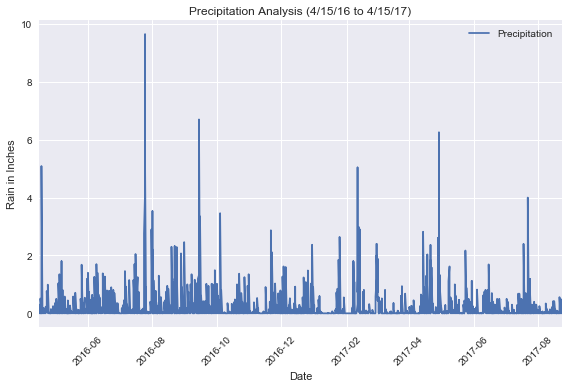

In [17]:
# plot the dataframe
rain_df.plot('date', 'prcp')
plt.xlabel("Date")
plt.ylabel("Rain in Inches")
plt.title("Precipitation Analysis (4/15/16 to 4/15/17)")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:
# Print summary statistics for the precipitation data.
rain_df.describe()

,prcp
count,3044.000000
mean,0.177057
std,0.503408
min,0.000000
25%,0.000000
50%,0.010000
75%,0.130000
max,9.640000


### Station Analysis

* Design a query to calculate the total number of stations.

* Design a query to find the most active stations.

  * List the stations and observation counts in descending order

  * Which station has the highest number of observations?

* Design a query to retrieve the last 12 months of temperature observation data (tobs).

  * Filter by the station with the highest number of observations.

  * Plot the results as a histogram with `bins=12`.

  <center><img src='images/temp_hist.png' height="400px" /></center>

In [19]:
# Count number of stations in Measurement table
locations = session.query(Measurements).group_by(Measurements.station).count()
print("There are {} stations.".format(locations))

There are 9 stations.


In [20]:
# find the station with the most temperature observations, then list them all in descending order
busy_station = session.query(Measurements.station, func.count(Measurements.tobs)).group_by(Measurements.station).\
               order_by(func.count(Measurements.tobs).desc()).all()

busiest = busy_station[0][0]    
print("The busiest station was",busiest,"with",busy_station[0][1],"weather observations.")
print()
print("Here are all of the Stations (in descending order) with their number of observations:")
for station, count in busy_station:
    print("Station",station,"had",count, "weather observations.")

The busiest station was USC00519281 with 2772 weather observations.

Here are all of the Stations (in descending order) with their number of observations:
Station USC00519281 had 2772 weather observations.
Station USC00519397 had 2724 weather observations.
Station USC00513117 had 2709 weather observations.
Station USC00519523 had 2669 weather observations.
Station USC00516128 had 2612 weather observations.
Station USC00514830 had 2202 weather observations.
Station USC00511918 had 1979 weather observations.
Station USC00517948 had 1372 weather observations.
Station USC00518838 had 511 weather observations.


In [21]:
# query to pull the last year of precipitation data for the busiest station
temperature = session.query(Measurements.station, Measurements.date, Measurements.tobs).\
    filter(Measurements.station == busiest).\
    filter(Measurements.date > last_year).\
    order_by(Measurements.date).all()

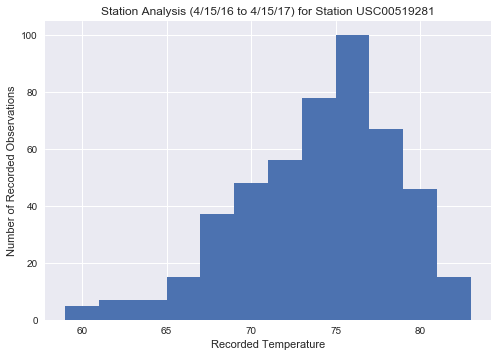

In [22]:
# plot Temps in a histogram with 12 bins
temp_df=pd.DataFrame(temperature)
plt.hist(temp_df['tobs'],12)
plt.xlabel("Recorded Temperature")
plt.ylabel("Recorded Observation Count")
plt.title("Station Analysis (4/15/16 to 4/15/17) for Station " + busiest)
plt.show()

### Temperature Analysis

* Write a function called `calc_temps` that will accept a start date and end date in the format `%Y-%m-%d` and return the minimum, average, and maximum temperatures for that range of dates.

* Use the `calc_temps` function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e. use "2017-01-01" if your trip start date was "2018-01-01")

* Plot the min, avg, and max temperature from your previous query as a bar chart.

  * Use the average temperature as the bar height.

  * Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).

<center><img src='images/temp_avg.png' height="400px"/></center>

In [26]:
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurements.tobs), func.avg(Measurements.tobs), func.max(Measurements.tobs)).\
        filter(Measurements.date >= start_date).filter(Measurements.date <= end_date).all()
temp_range = (calc_temps('2016-04-15', '2017-04-15'))
print(temp_range)

[(59.0, 74.36919739696313, 84.0)]


In [24]:
# calculate the min/max/avg from last year that matches my trip date
trip_arrive = dt.date(2017, 4, 1)
trip_leave = dt.date(2017, 4, 15)
last_year = dt.timedelta(days=365)
temp_avg_lst_year = (calc_temps((trip_arrive-last_year), (trip_leave-last_year)))
print(temp_avg_lst_year)

[(65.0, 73.41052631578947, 79.0)]


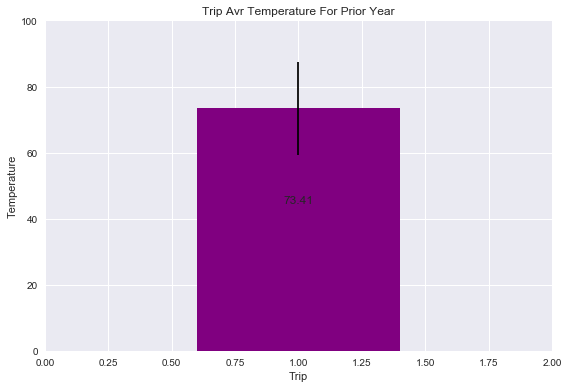

In [31]:
# plot the calculated min/max/avg from last year for the trip dates as a bar chart

p2p = temp_avg_lst_year[0][2]-temp_avg_lst_year[0][0]
avgtemp = temp_avg_lst_year[0][1]
min_temp = temp_avg_lst_year[0][0]
max_temp = temp_avg_lst_year[0][2]

fig, ax = plt.subplots()
bar_chart = ax.bar(1 , avgtemp, color= 'purple', yerr=p2p)
ax.set_xlabel("Trip")
ax.set_ylabel("Temperature")
ax.set_title("Trip Avr Temperature For Prior Year")

def autolabels(rects):
    for rect in rects:
        h=rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., .6*h,'%.2f' % float(h) ,ha='center', va='bottom', fontsize=12)

        
    # label the bars 
autolabels(bar_chart)        
plt.ylim(0, 100)
plt.xlim(0,2)
fig.tight_layout()
plt.show()

### Optional Recommended Analysis

* The following are optional challenge queries. These are highly recommended to attempt, but not required for the homework.

 * Calculate the rainfall per weather station using the previous year's matching dates.

* Calculate the daily normals. Normals are the averages for min, avg, and max temperatures.

 * Create a function called `daily_normals` that will calculate the daily normals for a specific date. This date string will be in the format `%m-%d`. Be sure to use all historic tobs that match that date string.

 * Create a list of dates for your trip in the format `%m-%d`. Use the `daily_normals` function to calculate the normals for each date string and append the results to a list.

* Load the list of daily normals into a Pandas DataFrame and set the index equal to the date.

  * Use Pandas to plot an area plot (`stacked=False`) for the daily normals.

  <center><img src="images/daily_normals.png" /></center>